# TinyFPGAで音源を作ってみる（計算メモ）

[TinyFPGA BX](https://tinyfpga.com/bx/guide.html)で音源を作ってみる。
そのために必要だった計算等のメモ  
原理は至極単純でFPGAの組込みRAMに1周期分の波形データを初期値として保存しておいて音程(pitch)に対応したクロック周期(マスタクロックの分周で作る)で逐次データ読みだしてPWM変調出力してオーディオアンプに入力して音を出す。それだけ、


＜概略仕様＞  
波形RAMデータ分解能:16bit  
波形RAMデータ長：512  

マスタクロック周波数：64MHz  

PWMキャリア周波数 : 44.1kHz  
PWM分解能 :9bit  
PWM電圧レベル:3.3V  


## 平均律の周波数

A4 = 440Hzを基準に平均律の周波数とFPGAの波形再生用基準クロック(64MHz)の分周器の分周率div_num(正確には分周器の設計上分周率-1)を求める。

まずA4を基準に半音ずつ低い音　A4→G3#→G3→F3#→F3→E3、、、、の周波数をもとめる。　　
($2^{1/12}$を逐次割っていくことで求まる)

In [1]:
pitch=[440]
last_pitch=440
for i in range(26):
    last_pitch/=2.**(1./12)
    pitch+=[last_pitch]


In [2]:
pitch

[440,
 415.3046975799451,
 391.99543598174927,
 369.99442271163434,
 349.2282314330038,
 329.62755691286986,
 311.1269837220808,
 293.66476791740746,
 277.18263097687196,
 261.6255653005985,
 246.94165062806192,
 233.08188075904482,
 219.99999999999986,
 207.65234878997242,
 195.9977179908745,
 184.99721135581706,
 174.6141157165018,
 164.81377845643482,
 155.56349186104032,
 146.83238395870364,
 138.59131548843592,
 130.8127826502992,
 123.4708253140309,
 116.54094037952235,
 109.99999999999987,
 103.82617439498615,
 97.99885899543719]

もとめた各ピッチの周波数とマスタクロック周波数64MHz,波形メモリ長512より、対応する分周比-1をもとめる。  
この値をVerilogのパラメータとして持たせておいて分周器の入力としての分周率を可変にすることでピッチ調整のメカニズムにする。

例えばA4を出す場合は64MHzを282+1=284分周したクロックで波形データを読む。

In [3]:
div_num=[]
for f in pitch:
    div_num+=[int(64000000./(512.*f)-0.5)]

In [4]:
div_num

[283,
 300,
 318,
 337,
 357,
 378,
 401,
 425,
 450,
 477,
 505,
 535,
 567,
 601,
 637,
 675,
 715,
 757,
 803,
 850,
 901,
 955,
 1011,
 1072,
 1135,
 1203,
 1275]

まずA4より高い音に対しても同様にもとめる。高い音は分周率を求める際の丸め誤差が相対的に大きくなるのでマスタクロックの周波数を上げないと音痴になる。
64MHz以上にしたかったがPLLが安定しないのであきらめた。


In [5]:
pitch=[440]
last_pitch=440
for i in range(26):
    last_pitch*=2.**(1./12)
    pitch+=[last_pitch]


In [6]:
pitch

[440,
 466.1637615180899,
 493.8833012561241,
 523.2511306011974,
 554.3652619537443,
 587.3295358348153,
 622.253967444162,
 659.2551138257401,
 698.456462866008,
 739.988845423269,
 783.9908719634989,
 830.6093951598906,
 880.0000000000003,
 932.3275230361802,
 987.7666025122486,
 1046.502261202395,
 1108.7305239074888,
 1174.6590716696307,
 1244.5079348883241,
 1318.5102276514804,
 1396.9129257320162,
 1479.9776908465383,
 1567.981743926998,
 1661.2187903197814,
 1760.000000000001,
 1864.6550460723606,
 1975.5332050244976]

In [7]:
div_num=[]
for f in pitch:
    div_num+=[int(64000000./(512.*f)-0.5)]

In [8]:
div_num

[283,
 267,
 252,
 238,
 224,
 212,
 200,
 189,
 178,
 168,
 158,
 149,
 141,
 133,
 126,
 118,
 112,
 105,
 99,
 94,
 88,
 83,
 79,
 74,
 70,
 66,
 62]

## TinyFPGAのRAM初期値格納データ(Verilog HDL)生成コード


TinyFPGAで音声データを出力する原波形データを作成する。

512長のRAM(16bit)に一周期分のデータを保存する。

16bit符号なし整数で0.5オフセットした振幅0.5の正弦波を生成する。
プロットは3周期分プロットしているがメモリデータとするのは１周期分512データ

In [9]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

f_name="ramdata_init.v"



instans_name="RAM_inst"

x=np.linspace(0,2*np.pi*4,512*4,endpoint=False)
y=0.5+0.5*np.sin(x)

#y=0.5+0.17*(np.sin(x)/5.0+np.sin(2*x)/1.5++np.sin(3*x)/1.0+np.sin(4*x)/1.3+np.sin(5*x)/2.0++np.sin(6*x)/3.0)
#y=1.0-(np.exp(-0.35*x))

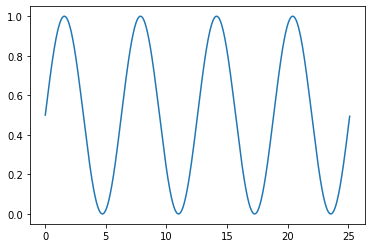

In [10]:
plt.plot(x,y)

0-1の範囲を16bit符号なし整数データ(0-65535)に変換

In [11]:
y_data=(y*(2**16-1)).astype(np.uint16)

In [12]:
np.max(y_data),np.min(y_data)

(65535, 0)

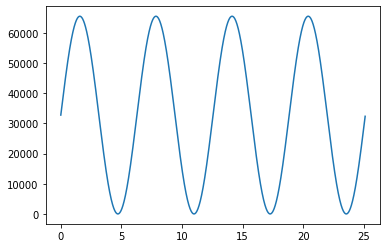

In [13]:
plt.plot(x,y_data)

FPGA([iCE40](https://www.latticesemi.com/ja-JP/Products/FPGAandCPLD/iCE40))のメモリインスタンスの初期値を設定するVerilog HDLコードを生成する。 
iCE40のRAMブロックは1ブロック4kbit(256x16bit)なので2ブロック分のRAMブロックインスタンス(RAM_inst0 , RAM_inst1)のデータを生成する。

In [14]:
mem_data=[]


#4kbit RAM block 1

for i in range(16):
    str_buf="defparam "+instans_name+"0.INIT_"+"{:1X} = 256'h".format(i)
    for j in range(16):
        str_buf += "{:04X}".format(y_data[i*16+15-j])
        if(j!=15):
            str_buf += "_"
    str_buf += ";"    
    mem_data+=[str_buf]

mem_data += [""]

#4kbit RAM block 2

for i in range(16):
    str_buf="defparam "+instans_name+"1.INIT_"+"{:1X} = 256'h".format(i)
    for j in range(16):
        str_buf+="{:04X}".format(y_data[(i+16)*16+15-j])
        if(j!=15):
            str_buf += "_"
    str_buf += ";"        
    mem_data+=[str_buf]   

In [15]:
mem_data

["defparam RAM_inst0.INIT_0 = 256'h976D_95E1_9454_92C7_9139_8FAA_8E1B_8C8B_8AFA_896A_87D8_8647_84B5_8323_8191_7FFF;",
 "defparam RAM_inst0.INIT_1 = 256'hAF86_AE10_AC98_AB1E_A9A3_A826_A6A7_A527_A3A5_A223_A09E_9F19_9D92_9C0A_9A82_98F8;",
 "defparam RAM_inst0.INIT_2 = 256'hC5CC_C47A_C324_C1CD_C073_BF16_BDB7_BC55_BAF2_B98C_B823_B6B9_B54C_B3DE_B26D_B0FB;",
 "defparam RAM_inst0.INIT_3 = 256'hD963_D842_D71D_D5F4_D4C9_D39A_D268_D132_CFFA_CEBF_CD80_CC3F_CAFA_C9B3_C869_C71C;",
 "defparam RAM_inst0.INIT_4 = 256'hE98B_E8A5_E7BC_E6CE_E5DD_E4E7_E3EE_E2F1_E1F0_E0EB_DFE2_DED6_DDC6_DCB3_DB9C_DA81;",
 "defparam RAM_inst0.INIT_5 = 256'hF5A4_F503_F45E_F3B4_F306_F254_F19D_F0E1_F022_EF5E_EE95_EDC9_ECF8_EC23_EB4A_EA6C;",
 "defparam RAM_inst0.INIT_6 = 256'hFD38_FCE2_FC88_FC28_FBC4_FB5C_FAEE_FA7C_FA04_F989_F908_F883_F7F9_F76B_F6D8_F640;",
 "defparam RAM_inst0.INIT_7 = 256'hFFFC_FFF5_FFE8_FFD7_FFC1_FFA6_FF86_FF61_FF37_FF08_FED4_FE9C_FE5E_FE1C_FDD5_FD89;",
 "defparam RAM_inst0.INIT_8 = 256'hFDD5_FE1C_FE5E_FE9C_F

あとは生成したコードを出力してCopy and PasteでVerilog HDLとして使うだけ、、　　
ファイル出力してもいいと思ったけど特に必要性も感じないのでこの程度に、、、

In [16]:
for line in mem_data:
    print(line)



defparam RAM_inst0.INIT_0 = 256'h976D_95E1_9454_92C7_9139_8FAA_8E1B_8C8B_8AFA_896A_87D8_8647_84B5_8323_8191_7FFF;
defparam RAM_inst0.INIT_1 = 256'hAF86_AE10_AC98_AB1E_A9A3_A826_A6A7_A527_A3A5_A223_A09E_9F19_9D92_9C0A_9A82_98F8;
defparam RAM_inst0.INIT_2 = 256'hC5CC_C47A_C324_C1CD_C073_BF16_BDB7_BC55_BAF2_B98C_B823_B6B9_B54C_B3DE_B26D_B0FB;
defparam RAM_inst0.INIT_3 = 256'hD963_D842_D71D_D5F4_D4C9_D39A_D268_D132_CFFA_CEBF_CD80_CC3F_CAFA_C9B3_C869_C71C;
defparam RAM_inst0.INIT_4 = 256'hE98B_E8A5_E7BC_E6CE_E5DD_E4E7_E3EE_E2F1_E1F0_E0EB_DFE2_DED6_DDC6_DCB3_DB9C_DA81;
defparam RAM_inst0.INIT_5 = 256'hF5A4_F503_F45E_F3B4_F306_F254_F19D_F0E1_F022_EF5E_EE95_EDC9_ECF8_EC23_EB4A_EA6C;
defparam RAM_inst0.INIT_6 = 256'hFD38_FCE2_FC88_FC28_FBC4_FB5C_FAEE_FA7C_FA04_F989_F908_F883_F7F9_F76B_F6D8_F640;
defparam RAM_inst0.INIT_7 = 256'hFFFC_FFF5_FFE8_FFD7_FFC1_FFA6_FF86_FF61_FF37_FF08_FED4_FE9C_FE5E_FE1C_FDD5_FD89;
defparam RAM_inst0.INIT_8 = 256'hFDD5_FE1C_FE5E_FE9C_FED4_FF08_FF37_FF61_FF86_FFA6_FFC1_

## 実際のwavデータから

正弦波の音はピーピーって感じで味気ないので倍音成分を加えて楽器みたいにしたい、、とおもい適当な関数とかフーリエ級数でいろいろな波形を適当に作ってやってみても思うようにできなかった。  
なので生音の波形を調べて、それをもとに波形を合成してみるアプローチをとることにした。


生音を保存されたwavファイルのデータ数値化は[PySoundFile](https://pypi.org/project/SoundFile/)でできるようである。  
(anacondaのパッケージには入ってなかったのでpipでインストールした。)

音源のwavファイルは以下サイトに適当なのがあった。

[https://www.cs.miyazaki-u.ac.jp/~date/lectures/2009ics/kadai/sound2009ics.html](https://www.cs.miyazaki-u.ac.jp/~date/lectures/2009ics/kadai/sound2009ics.html)


#### トランペット音

まずはトランペットの音のwavファイルの波形を調べて、フーリエ級数による合成を試みる。

In [17]:
import soundfile as sf
wav_file_path="target_data/doremi001t.wav"
data, samplerate = sf.read(wav_file_path)
sample_period=1./samplerate

In [18]:
samplerate,sample_period

(22050, 4.5351473922902495e-05)

In [19]:
t=np.linspace(0,data.shape[0]*sample_period,data.shape[0],endpoint=False)

In [20]:
t.shape

(429334,)

(0.398, 0.408)

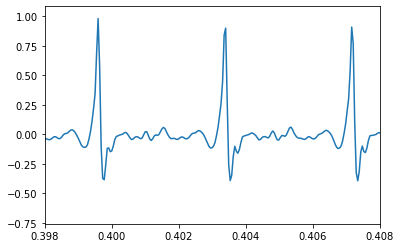

In [21]:
wav_data=np.ndarray((2,data.shape[0]),dtype=float)

wav_data[0,:]=t
wav_data[1,:]=data


plt.plot(wav_data[0],wav_data[1])
plt.xlim(0.398,0.408)

これはC2音(261.6Hz)発音部分の波形を拡大したもの

実際の波形は上記のようにとんがった波形になる模様

Scipyのfftモジュールをつかってフーリエ変換により周波数成分を調べる。

解析対象はC2音を出している以下の範囲(2周期分)とする

(0.3993, 0.40699)

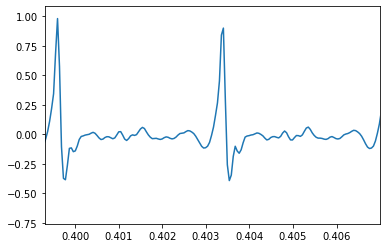

In [22]:
plt.plot(wav_data[0],wav_data[1])
plt.xlim(0.3993,0.40699)
#plt.xlim(0.6456,0.65334)

ターゲットとなるデータを切り出す。


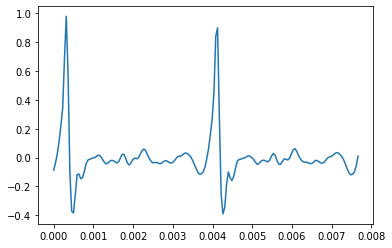

In [23]:
target_wav_data=wav_data[:,int(0.3993/sample_period):int(0.40699/sample_period)]

t0=target_wav_data[0,0]


target_wav_data[0,:]-=t0

plt.plot(target_wav_data[0],target_wav_data[1])

In [24]:
target_wav_data.shape

(2, 170)

In [25]:
target_wav_data[1].mean()

-0.0010327507467830883

ターゲット部分に離散時間フーリエ変換を実施。FFTライブラリとして[scipy.fft](https://docs.scipy.org/doc/scipy/reference/fft.html)を利用する。  
データ数nはだいたい1周期分である85を使う。  
結果は複素数の配列でとりあえず実部、虚部をプロットしてみる。。

In [26]:
import scipy.fft as fft

spectrum_data=fft.fft(target_wav_data[1],85)

In [27]:
type(spectrum_data)

numpy.ndarray

In [28]:
spectrum_data.dtype

dtype('complex128')

In [29]:
spectrum_data.shape

(85,)

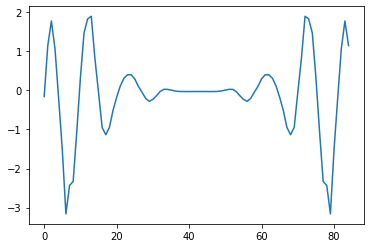

In [30]:
plt.plot(spectrum_data.real)

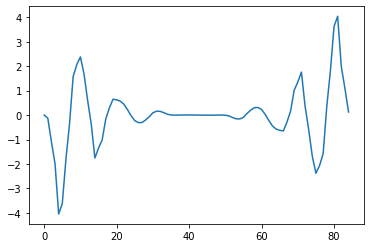

In [31]:
plt.plot(spectrum_data.imag)

もうちょっと突っ込んでみる絶対値と偏角計算し、横軸を実周波数にしたプロットをしてみる。。。

In [32]:
spectrum=np.ndarray((3,spectrum_data.shape[0]),dtype=float)
spectrum[0]=np.linspace(0,samplerate,spectrum_data.shape[0])
spectrum[1]=np.abs(spectrum_data)
spectrum[2]=np.angle(spectrum_data)

Text(0.5, 1.0, 'angle')

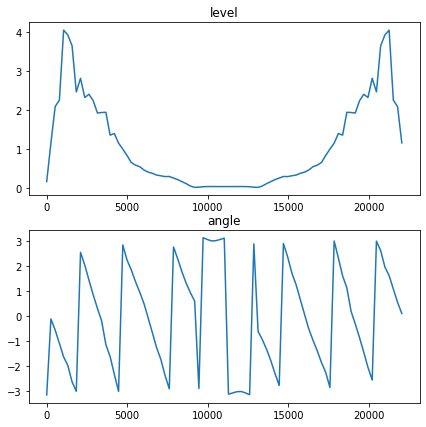

In [33]:
fig, axs = plt.subplots(2, 1,figsize=[7.,7.])   #2x1のマルチっプロットの作成

axs[0].plot(spectrum[0],spectrum[1])
axs[0].set_title("level")
#axs[0].set_xlim(100,2000)

axs[1].plot(spectrum[0],spectrum[2])
axs[1].set_title("angle")
#axs[1].set_xlim(100,2000)

横軸データは実周波数ではなく普通にn番目データとしてみたほうが今回の目的からは扱いやすそうなので横軸は無視すして
基本周波数、倍音成分のあるポイントを調べる。


Text(0.5, 1.0, 'angle')

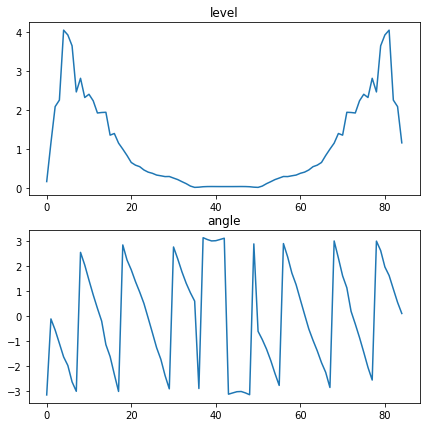

In [34]:
fig, axs = plt.subplots(2, 1,figsize=[7.,7.])   #2x1のマルチっプロットの作成

axs[0].plot(spectrum[1])
axs[0].set_title("level")
axs[1].plot(spectrum[2])
axs[1].set_title("angle")

(5, 15)

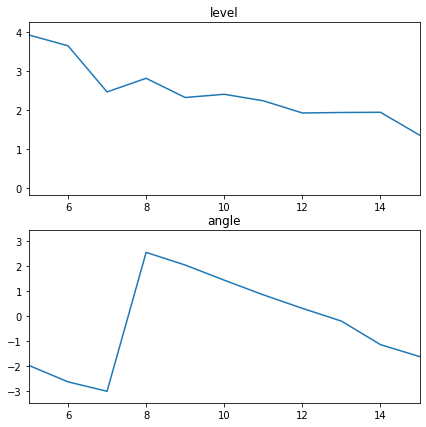

In [35]:
fig, axs = plt.subplots(2, 1,figsize=[7.,7.])   #2x1のマルチっプロットの作成

fc=10

axs[0].plot(spectrum[1])
axs[0].set_title("level")
axs[0].set_xlim(fc-5,fc+5)
axs[1].plot(spectrum[2])
axs[1].set_title("angle")
axs[1].set_xlim(fc-5,fc+5)

以上のようにｎを1周期分になるようにしたので

n倍高調波の成分はn番目のフーリエ変換データになる。

40倍高調波の成分のフーリエ級数のパラメータ(振幅、位相)を以下のように取り出す。


In [36]:
freq=[]
f_param_amp=[]
f_param_ang=[]
for i in range(1,41):
    f_param_amp+=[spectrum[1,i]]
    f_param_ang+=[spectrum[2,i]]
    #f_param_ang+=[(spectrum[2,i-4:i+5]*spectrum[1,i-4:i+5]).mean()/spectrum[1,i]]
    freq+=[spectrum[0][i]]

In [37]:
f_param_amp

[1.153566732579127,
 2.0854422184432324,
 2.252642257809004,
 4.050891538243368,
 3.926783330431604,
 3.648230769784387,
 2.4628006628274295,
 2.81329175007271,
 2.3193417627958883,
 2.402364617030522,
 2.235190134702861,
 1.9216830773953866,
 1.933799515315378,
 1.939431599878991,
 1.3518202135458566,
 1.394070055147877,
 1.1465615955237565,
 0.9922997142481383,
 0.8291160397141598,
 0.6491490365869095,
 0.5803472213550568,
 0.5413186281987382,
 0.45661489578486986,
 0.40122133898819523,
 0.3710256153487108,
 0.32572060628079935,
 0.30721486104327045,
 0.28654242374987215,
 0.2888873660245154,
 0.24849969941641117,
 0.20950656346384672,
 0.1555653936285219,
 0.10480893295728894,
 0.04257717644259027,
 0.009095230885790952,
 0.014565010377943253,
 0.025799774643050364,
 0.030008644459481298,
 0.031029087429562396,
 0.030322090976351752]

In [38]:
f_param_ang

[-0.10836937777037416,
 -0.5522921875997353,
 -1.0842903308953569,
 -1.6233765046961768,
 -1.9657835565517185,
 -2.6194141582502857,
 -2.996102238647366,
 2.5470673177438288,
 2.041778934882312,
 1.437071849898988,
 0.8529329999940013,
 0.3136708192807784,
 -0.19564805904869023,
 -1.1342061839920146,
 -1.6104657127259532,
 -2.321577048721692,
 -3.0019398481916513,
 2.8438604403654346,
 2.241782929316419,
 1.851247684257929,
 1.3809702165652187,
 0.9626325347835549,
 0.507829384604127,
 -0.07129124498889426,
 -0.6589962926387889,
 -1.2565218710266834,
 -1.720089483814218,
 -2.3662534714638164,
 -2.897808177750973,
 2.761880495137647,
 2.2847514084164553,
 1.7669466218697356,
 1.31352538953788,
 0.9329663722516975,
 0.6032208946709633,
 -2.8854574016838135,
 3.1326110714628874,
 3.059926374407313,
 3.0039727844195134,
 3.0129382294766636]

試しに波形を再現してみる。  
30倍高調波までの再現


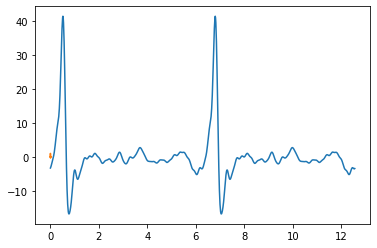

In [39]:
x=np.linspace(0,2*np.pi*2,512*2,endpoint=False)
y=np.zeros(512*2)
for i in range(1,31):
    y+=f_param_amp[i-1]*np.cos(i*x+f_param_ang[i-1])
plt.plot(x,y)
plt.plot(target_wav_data[0],target_wav_data[1])

元の波形を再掲

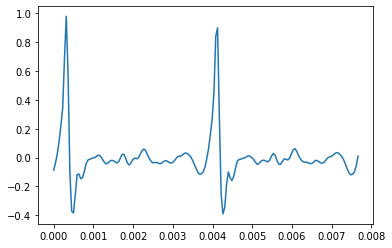

In [40]:
plt.plot(target_wav_data[0],target_wav_data[1])

見た目思いのほか高い再現度  
波形のレンジをノーマライズしてメモリ格納形式に変換する。

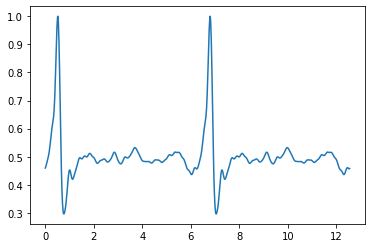

In [41]:
ymax=np.max(np.abs(y))
y_norm=y/(ymax*2.0)+0.5
y_data=(y_norm*(2**16-1)).astype(np.uint16)
plt.plot(x,y_norm)

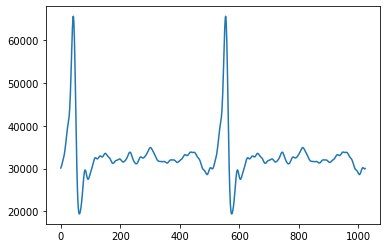

In [42]:
y_data=(y_norm*(2**16-1)).astype(np.uint16)
plt.plot(y_data)

In [43]:
mem_data=[]


#4kbit RAM block 1

for i in range(16):
    str_buf="defparam "+instans_name+"0.INIT_"+"{:1X} = 256'h".format(i)
    for j in range(16):
        str_buf += "{:04X}".format(y_data[i*16+15-j])
        if(j!=15):
            str_buf += "_"
    str_buf += ";"    
    mem_data+=[str_buf]

mem_data += [""]

#4kbit RAM block 2

for i in range(16):
    str_buf="defparam "+instans_name+"1.INIT_"+"{:1X} = 256'h".format(i)
    for j in range(16):
        str_buf+="{:04X}".format(y_data[(i+16)*16+15-j])
        if(j!=15):
            str_buf += "_"
    str_buf += ";"        
    mem_data+=[str_buf]   

for line in mem_data:
    print(line)

defparam RAM_inst0.INIT_0 = 256'h882C_8606_841F_8276_8104_7FBD_7E94_7D7C_7C68_7B55_7A3F_792A_7820_772B_7658_75B0;
defparam RAM_inst0.INIT_1 = 256'hB13F_ABFB_A7CD_A492_A213_A018_9E65_9CC8_9B17_9937_971D_94C9_9248_8FAD_8D10_8A89;
defparam RAM_inst0.INIT_2 = 256'hDCA4_E8D2_F2BD_FA07_FE77_FFFE_FEB6_FADF_F4D9_ED1F_E438_DAB1_D10F_C7C9_BF3D_B7AD;
defparam RAM_inst0.INIT_3 = 256'h4BF0_4BE0_4C7D_4DFF_50A3_54A7_5A42_619F_6AD4_75DE_8299_90C2_9FF7_AFBE_BF84_CEAF;
defparam RAM_inst0.INIT_4 = 256'h7166_6F53_6CBA_69B9_6672_630C_5FA9_5C68_5962_56A4_5437_5218_5046_4EBB_4D77_4C82;
defparam RAM_inst0.INIT_5 = 256'h6D00_6C3F_6BB3_6B6E_6B7C_6BE4_6CA4_6DAF_6EF2_704F_71A3_72C7_7396_73EE_73B7_72E0;
defparam RAM_inst0.INIT_6 = 256'h7C57_7B4F_7A35_7916_77FC_76F0_75F5_750C_7430_735C_7287_71AC_70C5_6FD3_6EDA_6DE5;
defparam RAM_inst0.INIT_7 = 256'h7F25_7EBE_7E67_7E2B_7E0F_7E13_7E34_7E6A_7EA9_7EE3_7F09_7F0E_7EE7_7E8D_7DFF_7D3F;
defparam RAM_inst0.INIT_8 = 256'h80C5_805B_800A_7FD8_7FC6_7FD2_7FF7_8029_805F_808C_80A7_

と波形データは作れたのだが思うような音として再生できてない、、、、

#### ストリングス音

 ストリングス音としてバイオリンの音の波形も同様に調べてみた。


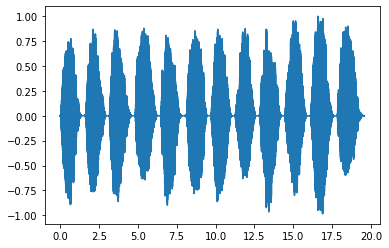

In [44]:
wav_file_path="target_data/doremi001v.wav"
data, samplerate = sf.read(wav_file_path)
sample_period=1./samplerate
t=np.linspace(0,data.shape[0]*sample_period,data.shape[0],endpoint=False)

wav_data=np.ndarray((2,data.shape[0]),dtype=float)

wav_data[0,:]=t
wav_data[1,:]=data

plt.plot(wav_data[0],wav_data[1])
#plt.xlim(0.5,0.7)

バイオリンはトランペットと違いビブラートがあって低周波の揺らぎが強い感じがするのだが、、、それはひとまず無視して先ほど同様2波長分のデータを使うこと位下。

(0.5521, 0.5598)

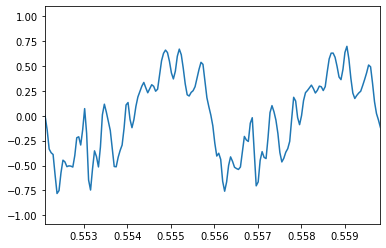

In [45]:
plt.plot(wav_data[0],wav_data[1])
plt.xlim(0.5521,0.5598)

データ切り出し

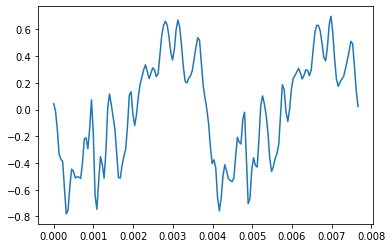

In [46]:
target_wav_data=wav_data[:,int(0.5521/sample_period):int(0.5598/sample_period)]

t0=target_wav_data[0,0]


target_wav_data[0,:]-=t0

plt.plot(target_wav_data[0],target_wav_data[1])

In [47]:
target_wav_data.shape

(2, 170)

先ほどと同様fftを施して振幅、位相プロットする。(nも同様170/2=85)とする

In [48]:
spectrum_data=fft.fft(target_wav_data[1],85)

spectrum=np.ndarray((3,spectrum_data.shape[0]),dtype=float)
spectrum[0]=np.linspace(0,samplerate,spectrum_data.shape[0])
spectrum[1]=np.abs(spectrum_data)
spectrum[2]=np.angle(spectrum_data)

Text(0.5, 1.0, 'angle')

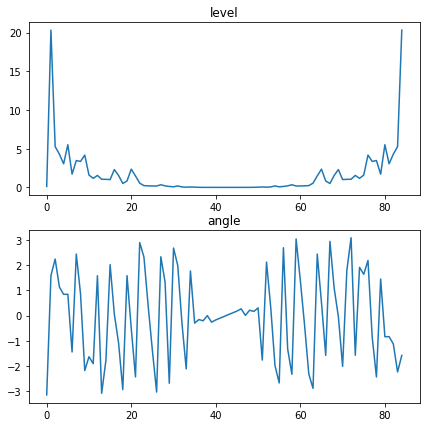

In [49]:
fig, axs = plt.subplots(2, 1,figsize=[7.,7.])   #2x1のマルチっプロットの作成

axs[0].plot(spectrum[1])
axs[0].set_title("level")
axs[1].plot(spectrum[2])
axs[1].set_title("angle")

先ほどと同様、40倍高調波の成分のフーリエ級数のパラメータ(振幅、位相)を取り出し25倍高調波までで再現してみる。


In [50]:
freq=[]
f_param_amp=[]
f_param_ang=[]
for i in range(1,41):
    f_param_amp+=[spectrum[1,i]]
    f_param_ang+=[spectrum[2,i]]
    #f_param_ang+=[(spectrum[2,i-4:i+5]*spectrum[1,i-4:i+5]).mean()/spectrum[1,i]]
    freq+=[spectrum[0][i]]

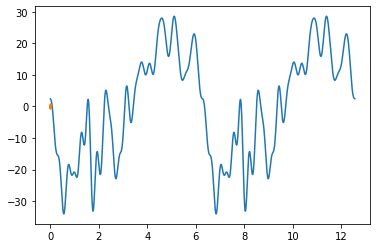

In [51]:
x=np.linspace(0,2*np.pi*2,512*2,endpoint=False)
y=np.zeros(512*2)
for i in range(1,26):
    y+=f_param_amp[i-1]*np.cos(i*x+f_param_ang[i-1])
plt.plot(x,y)
plt.plot(target_wav_data[0],target_wav_data[1])

元の波形を再掲

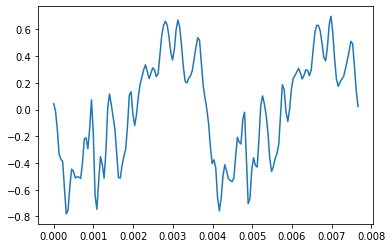

In [52]:
plt.plot(target_wav_data[0],target_wav_data[1])

波形のレンジをノーマライズしてメモリ格納形式に変換する。

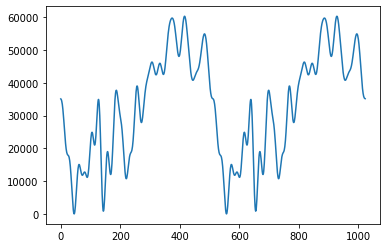

In [53]:
ymax=np.max(np.abs(y))
y_norm=y/(ymax*2.0)+0.5
y_data=(y_norm*(2**16-1)).astype(np.uint16)
plt.plot(y_data)

In [54]:
mem_data=[]


#4kbit RAM block 1

for i in range(16):
    str_buf="defparam "+instans_name+"0.INIT_"+"{:1X} = 256'h".format(i)
    for j in range(16):
        str_buf += "{:04X}".format(y_data[i*16+15-j])
        if(j!=15):
            str_buf += "_"
    str_buf += ";"    
    mem_data+=[str_buf]

mem_data += [""]

#4kbit RAM block 2

for i in range(16):
    str_buf="defparam "+instans_name+"1.INIT_"+"{:1X} = 256'h".format(i)
    for j in range(16):
        str_buf+="{:04X}".format(y_data[(i+16)*16+15-j])
        if(j!=15):
            str_buf += "_"
    str_buf += ";"        
    mem_data+=[str_buf]   

for line in mem_data:
    print(line)

defparam RAM_inst0.INIT_0 = 256'h57F2_5C64_6124_6612_6B0A_6FE8_748B_78D4_7CAB_7FFD_82C0_84F2_8698_87C2_8883_88F6;
defparam RAM_inst0.INIT_1 = 256'h3C59_3F53_41A0_434D_4473_4530_45A7_4600_4663_46F6_47DA_492C_4B02_4D68_5062_53EA;
defparam RAM_inst0.INIT_2 = 256'h027F_00AB_0000_0085_0236_0500_08C5_0D5F_129E_184F_1E3C_2430_29F7_2F66_3457_38AE;
defparam RAM_inst0.INIT_3 = 256'h3A1F_3AD2_3AD8_3A14_3874_35F1_3291_2E67_2991_2439_1E90_18CF_1330_0DF0_0948_0569;
defparam RAM_inst0.INIT_4 = 256'h31B4_313C_3090_2FCC_2F0C_2E70_2E12_2E0A_2E65_2F2B_3056_31D7_3396_3572_3744_38E1;
defparam RAM_inst0.INIT_5 = 256'h3AB9_3645_3283_2F8D_2D6C_2C1E_2B92_2BAA_2C45_2D37_2E56_2F7A_307E_3146_31C0_31E4;
defparam RAM_inst0.INIT_6 = 256'h5588_5807_5AB1_5D37_5F4F_60B9_6143_60CB_5F43_5CAF_5926_54CE_4FDA_4A85_450F_3FB7;
defparam RAM_inst0.INIT_7 = 256'h8855_87E1_8583_8182_7C3A_7612_6F77_68D5_6292_5D04_5870_5507_52E0_51FB_5240_5383;
defparam RAM_inst0.INIT_8 = 256'h0347_04F5_08EF_0F25_176A_2178_2CEF_395F_464A_532D_5F83_

#### クラリネット音

木管音としてクラリネットの音の波形も、、、

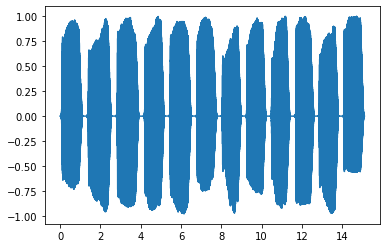

In [75]:
wav_file_path="target_data/doremi001c.wav"
data, samplerate = sf.read(wav_file_path)
sample_period=1./samplerate
t=np.linspace(0,data.shape[0]*sample_period,data.shape[0],endpoint=False)

wav_data=np.ndarray((2,data.shape[0]),dtype=float)

wav_data[0,:]=t
wav_data[1,:]=data

plt.plot(wav_data[0],wav_data[1])
#plt.xlim(0.5,0.7)

感覚としては意外と電子音でも行けそうな感じ

(0.5551, 0.5637)

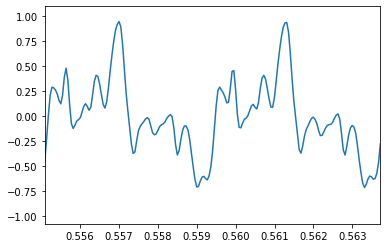

In [76]:
plt.plot(wav_data[0],wav_data[1])
plt.xlim(0.5551,0.5637)

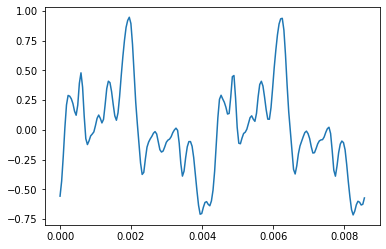

In [77]:
target_wav_data=wav_data[:,int(0.5551/sample_period):int(0.5637/sample_period)]

t0=target_wav_data[0,0]


target_wav_data[0,:]-=t0

plt.plot(target_wav_data[0],target_wav_data[1])

In [78]:
target_wav_data.shape

(2, 190)

190??

ちょっとこれまでのとピッチが違うような、、

一応サンプリングレートも確認してみるても同じなので2周期190サンプルでこれまで(170)とちょっと違う模様

フーリエ変換はn=95にすればいいので特に問題はないけど少し気になる。・

In [71]:
samplerate

22050

Text(0.5, 1.0, 'angle')

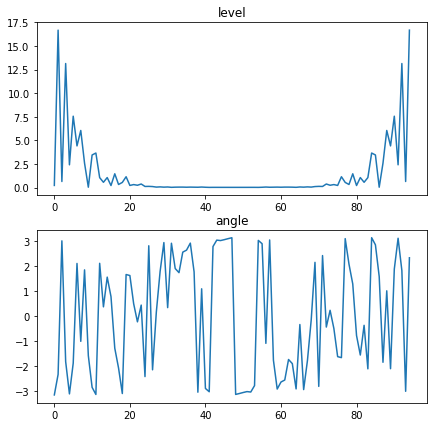

In [74]:
spectrum_data=fft.fft(target_wav_data[1],95)

spectrum=np.ndarray((3,spectrum_data.shape[0]),dtype=float)
spectrum[0]=np.linspace(0,samplerate,spectrum_data.shape[0])
spectrum[1]=np.abs(spectrum_data)
spectrum[2]=np.angle(spectrum_data)

fig, axs = plt.subplots(2, 1,figsize=[7.,7.])   #2x1のマルチっプロットの作成

axs[0].plot(spectrum[1])
axs[0].set_title("level")
axs[1].plot(spectrum[2])
axs[1].set_title("angle")

40倍高調波の成分のフーリエ級数のパラメータ(振幅、位相)を取り出し25倍高調波までで再現。

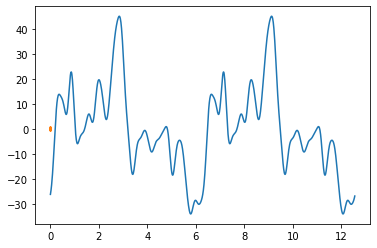

In [79]:
freq=[]
f_param_amp=[]
f_param_ang=[]
for i in range(1,41):
    f_param_amp+=[spectrum[1,i]]
    f_param_ang+=[spectrum[2,i]]
    #f_param_ang+=[(spectrum[2,i-4:i+5]*spectrum[1,i-4:i+5]).mean()/spectrum[1,i]]
    freq+=[spectrum[0][i]]
    
x=np.linspace(0,2*np.pi*2,512*2,endpoint=False)
y=np.zeros(512*2)
for i in range(1,26):
    y+=f_param_amp[i-1]*np.cos(i*x+f_param_ang[i-1])
plt.plot(x,y)
plt.plot(target_wav_data[0],target_wav_data[1])

元の波形を再掲

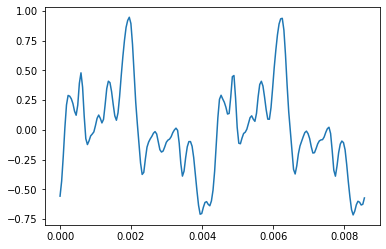

In [80]:
plt.plot(target_wav_data[0],target_wav_data[1])

defparam RAM_inst0.INIT_0 = 256'h7C19_75E6_6F9F_695A_6332_5D3C_578C_5231_4D39_48AB_448C_40DE_3D9C_3AC1_3845_361E;
defparam RAM_inst0.INIT_1 = 256'hA734_A777_A78C_A764_A6ED_A618_A4D5_A317_A0D2_9E01_9A9F_96AF_9237_8D41_87DE_821E;
defparam RAM_inst0.INIT_2 = 256'h97CA_9989_9B3A_9CD0_9E43_9F8F_A0B2_A1B0_A28E_A352_A402_A4A5_A53E_A5CF_A657_A6D0;
defparam RAM_inst0.INIT_3 = 256'hAD2A_A88B_A3FF_9FB1_9BC5_985A_9585_9356_91D1_90F4_90B6_9105_91CD_92F8_946B_960E;
defparam RAM_inst0.INIT_4 = 256'h9B7F_A1EE_A82D_AE0C_B35D_B7F6_BBB3_BE79_C035_C0E0_C07C_BF17_BCC6_B9A9_B5E8_B1AE;
defparam RAM_inst0.INIT_5 = 256'h721E_7120_704D_6FBE_6F8A_6FC8_7090_71F5_7406_76CE_7A4F_7E86_8367_88DC_8ECA_950E;
defparam RAM_inst0.INIT_6 = 256'h7CE4_7C51_7BD6_7B6B_7B0A_7AAD_7A4D_79E2_7965_78D1_7822_7755_766B_7568_7453_7335;
defparam RAM_inst0.INIT_7 = 256'h9058_8F86_8E79_8D3B_8BD7_8A59_88CD_873C_85B2_8436_82CF_8182_8055_7F48_7E5C_7D91;
defparam RAM_inst0.INIT_8 = 256'h8889_87EF_87CB_8813_88B5_899E_8ABA_8BF1_8D2D_8E5A_8F64_

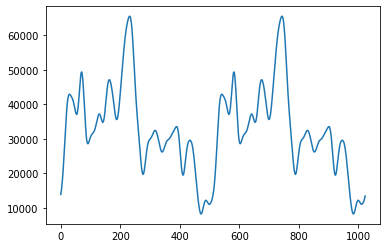

In [81]:
ymax=np.max(np.abs(y))
y_norm=y/(ymax*2.0)+0.5
y_data=(y_norm*(2**16-1)).astype(np.uint16)
plt.plot(y_data)

mem_data=[]


#4kbit RAM block 1

for i in range(16):
    str_buf="defparam "+instans_name+"0.INIT_"+"{:1X} = 256'h".format(i)
    for j in range(16):
        str_buf += "{:04X}".format(y_data[i*16+15-j])
        if(j!=15):
            str_buf += "_"
    str_buf += ";"    
    mem_data+=[str_buf]

mem_data += [""]

#4kbit RAM block 2

for i in range(16):
    str_buf="defparam "+instans_name+"1.INIT_"+"{:1X} = 256'h".format(i)
    for j in range(16):
        str_buf+="{:04X}".format(y_data[(i+16)*16+15-j])
        if(j!=15):
            str_buf += "_"
    str_buf += ";"        
    mem_data+=[str_buf]   

for line in mem_data:
    print(line)

#### オルガン音

最後オルガンの音の波形も、、、

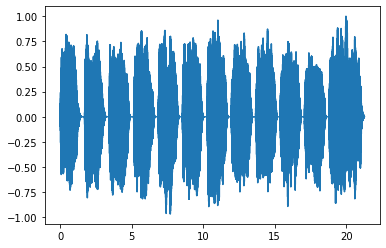

In [82]:
wav_file_path="target_data/doremi001o.wav"
data, samplerate = sf.read(wav_file_path)
sample_period=1./samplerate
t=np.linspace(0,data.shape[0]*sample_period,data.shape[0],endpoint=False)

wav_data=np.ndarray((2,data.shape[0]),dtype=float)

wav_data[0,:]=t
wav_data[1,:]=data

plt.plot(wav_data[0],wav_data[1])
#plt.xlim(0.5,0.7)

(0.5436, 0.5589)

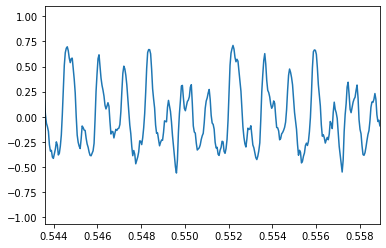

In [100]:
plt.plot(wav_data[0],wav_data[1])
plt.xlim(0.5436,0.5589)

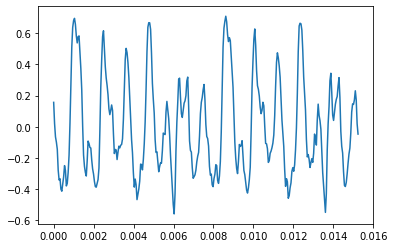

In [101]:
target_wav_data=wav_data[:,int(0.5436/sample_period):int(0.5589/sample_period)]

t0=target_wav_data[0,0]


target_wav_data[0,:]-=t0

plt.plot(target_wav_data[0],target_wav_data[1])

In [102]:
target_wav_data.shape

(2, 337)

Text(0.5, 1.0, 'angle')

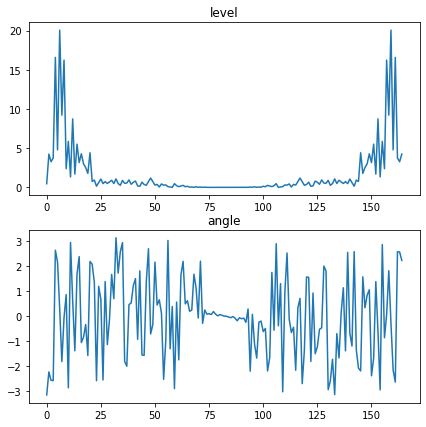

In [106]:
spectrum_data=fft.fft(target_wav_data[1],165)

spectrum=np.ndarray((3,spectrum_data.shape[0]),dtype=float)
spectrum[0]=np.linspace(0,samplerate,spectrum_data.shape[0])
spectrum[1]=np.abs(spectrum_data)
spectrum[2]=np.angle(spectrum_data)

fig, axs = plt.subplots(2, 1,figsize=[7.,7.])   #2x1のマルチっプロットの作成

axs[0].plot(spectrum[1])
axs[0].set_title("level")
axs[1].plot(spectrum[2])
axs[1].set_title("angle")

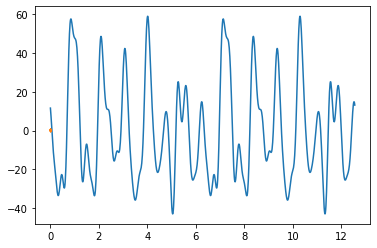

In [107]:
freq=[]
f_param_amp=[]
f_param_ang=[]
for i in range(1,41):
    f_param_amp+=[spectrum[1,i]]
    f_param_ang+=[spectrum[2,i]]
    #f_param_ang+=[(spectrum[2,i-4:i+5]*spectrum[1,i-4:i+5]).mean()/spectrum[1,i]]
    freq+=[spectrum[0][i]]
    
x=np.linspace(0,2*np.pi*2,512*2,endpoint=False)
y=np.zeros(512*2)
for i in range(1,26):
    y+=f_param_amp[i-1]*np.cos(i*x+f_param_ang[i-1])
plt.plot(x,y)
plt.plot(target_wav_data[0],target_wav_data[1])

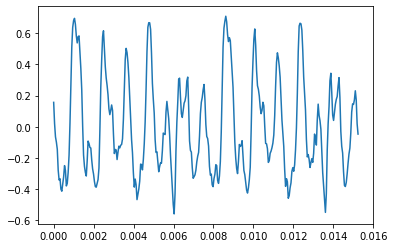

In [108]:
plt.plot(target_wav_data[0],target_wav_data[1])

defparam RAM_inst0.INIT_0 = 256'h5607_5962_5CBF_6031_63CE_67AB_6BD7_705E_7540_7A73_7FE1_856C_8AEB_902D_9500_992F;
defparam RAM_inst0.INIT_1 = 256'h3F60_3C89_3A2C_3871_3775_3748_37EA_3951_3B66_3E0B_411E_447C_4803_4B97_4F24_52A0;
defparam RAM_inst0.INIT_2 = 256'h3FB5_3FEA_413F_435D_45ED_4897_4B0B_4D05_4E51_4ECD_4E6B_4D32_4B38_48A4_45A8_427E;
defparam RAM_inst0.INIT_3 = 256'hE403_DA08_CE88_C1BE_B3F6_A589_96DA_8852_7A5A_6D53_6195_5767_4EFB_486E_43C4_40E9;
defparam RAM_inst0.INIT_4 = 256'hE973_EABE_EC6B_EE78_F0D6_F36A_F60D_F890_FAB9_FC4A_FD03_FCA5_FAF5_F7C2_F2E9_EC54;
defparam RAM_inst0.INIT_5 = 256'hB360_BCB6_C526_CC99_D300_D85A_DCAF_E010_E297_E465_E59D_E669_E6F1_E760_E7DA_E882;
defparam RAM_inst0.INIT_6 = 256'h4A71_47E7_46A9_46E3_48B2_4C20_5125_57AD_5F91_689F_729C_7D46_8856_9387_9E97_A946;
defparam RAM_inst0.INIT_7 = 256'h6481_681B_6B53_6DF7_6FD8_70CE_70BF_6F9D_6D6C_6A40_663E_6198_5C8F_576B_527C_4E0F;
defparam RAM_inst0.INIT_8 = 256'h3EF5_4124_432F_4508_46AE_482D_4999_4B0A_4C9F_4E71_5097_

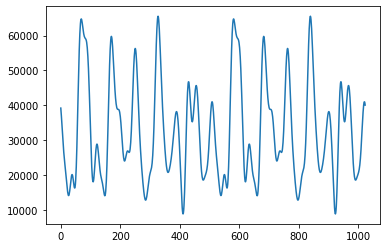

In [109]:
ymax=np.max(np.abs(y))
y_norm=y/(ymax*2.0)+0.5
y_data=(y_norm*(2**16-1)).astype(np.uint16)
plt.plot(y_data)

mem_data=[]


#4kbit RAM block 1

for i in range(16):
    str_buf="defparam "+instans_name+"0.INIT_"+"{:1X} = 256'h".format(i)
    for j in range(16):
        str_buf += "{:04X}".format(y_data[i*16+15-j])
        if(j!=15):
            str_buf += "_"
    str_buf += ";"    
    mem_data+=[str_buf]

mem_data += [""]

#4kbit RAM block 2

for i in range(16):
    str_buf="defparam "+instans_name+"1.INIT_"+"{:1X} = 256'h".format(i)
    for j in range(16):
        str_buf+="{:04X}".format(y_data[(i+16)*16+15-j])
        if(j!=15):
            str_buf += "_"
    str_buf += ";"        
    mem_data+=[str_buf]   

for line in mem_data:
    print(line)